In [1]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np

experiment,sys,dim = "NN","TodaLattice100",6
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-np.exp(x[0]-x[1])+np.exp(x[2]-x[0]),
                           -np.exp(x[1]-x[2])+np.exp(x[0]-x[1]),
                           -np.exp(x[2]-x[0])+np.exp(x[1]-x[2]),])
H = lambda x: 0.5*(x[3]**2+x[4]**2+x[5]**2)+np.exp(x[0]-x[1])+np.exp(x[1]-x[2])+np.exp(x[2]-x[0])-3

spacedim = [(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)] # by using this spacedim, x<1 therefore x**2<1. the hamiltonian will usually be negative.
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01

"""# Test dataset creation"""

from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import time 

# xxshort,yyshort = np.linspace(spacedim[0][0], spacedim[0][1], 20), np.linspace(spacedim[1][0], spacedim[1][1], 20)
# xshort,yshort = np.meshgrid(xxshort,yyshort)

# H_true = H(np.c_[np.ravel(xshort),np.ravel(yshort)].transpose())
# sample_points = np.expand_dims(np.c_[np.ravel(xshort),np.ravel(yshort)],2)

# def get_H_grad(model, z,device):
#     inputs=torch.unsqueeze(Variable(torch.tensor([z[0][0],z[1][0]]), requires_grad = True),0).to(device)
#     out=model(inputs.float())
#     dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True, allow_unused=True)[0].detach().cpu().numpy()
#     return out.detach().cpu().numpy(), dH[0][1],-dH[0][0] # negative dH/dq is dp/dt

In [4]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

class SumNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SumNet , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)
        x = torch.sum(x)

        return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [5]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics

for i in range(20):
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/h

    # delta2 = delta.copy()
    # delta2[0,:] = f1(start)
    # delta2[1,:] = f2(start)
    # dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    # dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    # data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = sepNet(3,71,71,1) #sepnet = sepNet(3,22,22,1)
    starttime = time.time() 
    print("training sepNet")

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    # results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(sepnet, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
    # file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = Net(6,100,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(net, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a')
    # file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    # print(septraintime, PINNtraintime)

training sepNet
 
epoch= 0  time= 0.18244600296020508  loss= 3.2522752646641098  val_loss= 3.9899254471571446  f1= 0.08618449504344723  f2= 0.5066510084124359  f3= 2.65943411466075  f4= 5.646547476533196e-06 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 
epoch= 2700  time= 53.749791860580444  loss= 0.0017481101523665913  val_loss= 0.004764604778725822  f1= 0.0001558739127837256  f2= 0.0013669635533304506  f3= 0.00015048839136018918  f4= 7.478429489222572e-05 num_batches= 6 percent lr= 0.01
 
epoch= 2800  time= 55.62521743774414  loss= 0.00014031096079652553  val_loss= 0.000956900756552606  f1= 2.3567566111398956e-05  f2= 6.800867892345729e-05  f3= 3.070094511355611e-05  f4= 1.8033770648113163e-05 num_batches= 6 percent lr= 0.01
 
epoch= 2900  time= 57.508803367614746  loss= 0.0005148252581541763  val_loss= 0.0018826235182628403  f1= 0.00015184315936177652  f2= 0.0001912875302235887  f3= 1.8067611563310493e-05  f4= 0.00015362695700550067 num_batches= 6 percent lr= 0.01
 
epoch= 3000  time= 59.42469930648804  loss= 0.0005516162938451853  val_loss= 0.0028226779252988467  f1= 8.02812939294096e-05  f2= 0.0004079605139208141  f3= 3.6653435439385853e-06  f4= 5.970914245102297e-05 num_batche

In [ ]:
# n_sample = 20
# dim = 6

# z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
#                                       np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
#                                       np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
#                                       ))).reshape(6, n_sample**dim).transpose(1,0)
# for i in tqdm(range(dim**2)):
#   np.savetxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/test%s.txt' %(sys,i), z[n_sample**4*i:n_sample**4*(i+1), :])

100%|██████████| 36/36 [00:50<00:00,  1.42s/it]


In [6]:
from tqdm import tqdm

n_sample = 20 # 6

sepnet_total, net_total = [],[]
for seed in tqdm(range(20)):
  for ini in initialcon:
    net = Net(6,100,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,71,71,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5],
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt
      # return np.asarray([dH.detach().to(device).numpy()[:,3], dH.detach().to(device).numpy()[:,4], dH.detach().to(device).numpy()[:,5],
      #               -dH.detach().to(device).numpy()[:,0], -dH.detach().to(device).numpy()[:,1], -dH.detach().to(device).numpy()[:,2], ]) # negative dH/dq is dp/dt

    
    f1 = lambda x: np.stack([x[:,3], x[:,4], x[:,5]])
    f2 = lambda x: np.stack([-np.exp(x[:,0]-x[:,1])+np.exp(x[:,2]-x[:,0]),
                              -np.exp(x[:,1]-x[:,2])+np.exp(x[:,0]-x[:,1]),
                              -np.exp(x[:,2]-x[:,0])+np.exp(x[:,1]-x[:,2]),])



    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    

    sepnet_error, net_error = 0, 0
    for i in range(6**2):
      inpz = torch.tensor(np.loadtxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/TodaLatticeNA/test%s.txt' %(i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

  0%|          | 0/20 [00:00<?, ?it/s]

64 136285.50806869543 103840.85408198606
128 72309.3195171478 59575.08205626797
256 63224.431311121276 65246.854285469184
512 58618.345431805865 43876.30278538256
1024 37496.134573218726 31011.569528561493


  5%|▌         | 1/20 [13:05<4:08:40, 785.28s/it]

2048 40982.41365340594 26010.257246071767
64 210634.60369644652 158601.94039584158
128 87319.54660258586 48921.70315571756
256 76569.66495339383 60619.09049123216
512 62395.211528434025 36476.93727761252
1024 47809.29253657546 28182.158456783716


 10%|█         | 2/20 [26:14<3:56:12, 787.39s/it]

2048 36815.97092291681 18401.46734944068
64 210587.9769700489 86825.39706553803
128 103184.14579131569 71553.6973012039
256 98037.71262407972 48456.02081563883
512 46265.25699742617 33208.70409544222
1024 55420.17368548076 39947.35623736704


 15%|█▌        | 3/20 [39:05<3:41:00, 780.05s/it]

2048 36218.70441314588 34873.28073080286
64 139212.63638940582 124664.23890207155
128 65452.75908193784 48356.368739128935
256 61896.55429585894 55205.488811857416
512 72448.90214999617 37502.83570043171
1024 41551.45027995768 46917.255446294745


 20%|██        | 4/20 [51:58<3:27:16, 777.31s/it]

2048 51047.33529090348 37773.725533383076
64 150923.48614875242 132804.41914719317
128 89886.6755976712 96839.70934165758
256 94969.13919130777 67422.27900363132
512 41351.41130996434 40756.08459923284
1024 44633.9298837993 25560.843537967612


 25%|██▌       | 5/20 [1:04:53<3:14:07, 776.48s/it]

2048 43938.64205291063 36300.19710735466
64 131695.47235602143 66233.00661108788
128 71839.91705113441 51541.2235490755
256 57702.440793845075 40786.67776889184
512 58280.014948027805 44810.120205249004
1024 45573.58578835754 29828.56030435224


 30%|███       | 6/20 [1:17:52<3:01:22, 777.30s/it]

2048 36068.9087627623 31057.085422280605
64 132066.44373514788 97175.67157322931
128 101353.8475464993 52487.98484655609
256 58539.440649153934 37590.1279965662
512 44141.50772708909 43849.41475123871
1024 39495.023211911706 24134.840817912394


 35%|███▌      | 7/20 [1:30:46<2:48:09, 776.08s/it]

2048 40431.114529071296 31357.231850024866
64 162752.03038112944 84069.34069637956
128 78533.48651564849 119640.53478223732
256 82104.67042337715 70100.92292546503
512 44639.79903228757 39002.23222217095
1024 45697.81325011289 32437.800467301706


 40%|████      | 8/20 [1:43:51<2:35:47, 778.92s/it]

2048 38364.911856581915 24142.899561197613
64 138137.32391934807 82700.40185861975
128 105159.98202996505 121212.67862512004
256 52308.040144038605 62388.82990524297
512 57923.02530513567 38427.769871074044
1024 33804.95249357793 33990.471730038276


 45%|████▌     | 9/20 [1:57:00<2:23:26, 782.37s/it]

2048 36590.978237068186 30737.70777746947
64 104143.80214784014 103799.75568462288
128 136995.23062853285 83399.19281151789
256 95377.86827085861 40652.700302287856
512 48675.6885382655 37034.27215978927
1024 36184.67025080265 31674.631222415534


 50%|█████     | 10/20 [2:10:16<2:11:04, 786.42s/it]

2048 51833.8356234169 27217.79193409075
64 249039.97588087228 223198.21989592887
128 86743.43660889889 87169.12497485112
256 129003.713060203 54385.088508021894
512 61666.21442668376 38067.25170272511
1024 46870.80541927102 37359.39170588532


 55%|█████▌    | 11/20 [2:23:34<1:58:29, 789.97s/it]

2048 44456.702784192785 27907.430185440564
64 146694.7231222035 137713.6467746133
128 126598.49322420968 73422.5648536834
256 46543.13242918194 69493.34359272973
512 76682.11586528599 50246.01537803938
1024 57837.88536821397 47937.10017085316


 60%|██████    | 12/20 [2:37:07<1:46:15, 796.97s/it]

2048 35696.593923759574 20149.65041672014
64 150894.11852384143 70653.66368117099
128 82883.78764278365 50424.94392930655
256 55318.55491140705 44677.948398488516
512 65916.94476465475 50459.26856531015
1024 43361.67682077314 29632.581087219598


 65%|██████▌   | 13/20 [2:50:33<1:33:18, 799.78s/it]

2048 34051.658393184065 23465.52578598215
64 101613.66881999036 78048.54124636317
128 137230.4275243875 46354.43851662577
256 85090.78583682455 62005.32293003053
512 60379.463929355465 38469.08391008647
1024 38050.28647124458 36049.61816443784


 70%|███████   | 14/20 [3:03:45<1:19:44, 797.41s/it]

2048 38592.413883123816 33703.57868751627
64 141173.27796020178 63557.47809660561
128 72631.93001859379 95484.6998195342
256 66390.66286991688 44673.3939857542
512 52195.99975080255 36267.447663764186
1024 43131.60286690556 29191.706650485186


 75%|███████▌  | 15/20 [3:16:50<1:06:08, 793.68s/it]

2048 35815.447185991485 28110.31195798293
64 327626.90550796065 190357.79214863118
128 136538.477673828 59076.605721229615
256 102609.1767973974 55080.48227529073
512 43555.76361627055 39552.272489084506
1024 39718.12772945417 48384.62135834038


 80%|████████  | 16/20 [3:29:52<52:40, 790.19s/it]  

2048 43021.009832907715 23712.279710255512
64 197126.48199864436 113811.35039211017
128 150069.46444415994 62880.1358844276
256 52109.324282834896 52788.51904736991
512 51050.89300314596 41121.59042382667
1024 38018.67462247619 39230.886743957766


 85%|████████▌ | 17/20 [3:42:51<39:20, 786.72s/it]

2048 47899.20818286972 25303.226753157058
64 109168.07071188214 72368.17502424595
128 100073.58465999077 77749.97228567605
256 66608.8444793663 54192.78401861928
512 47342.89386065305 46155.97541573521
1024 49923.56987589506 34827.414007016916


 90%|█████████ | 18/20 [3:55:53<26:10, 785.25s/it]

2048 42833.84926470451 30108.768801464925
64 142110.74412063288 76261.08092318219
128 93958.26406663425 50827.203251809995
256 84806.85311385008 35229.68933645585
512 75785.32491050064 38523.84927678673
1024 44392.09811584485 30545.191833448243


 95%|█████████▌| 19/20 [4:08:51<13:03, 783.13s/it]

2048 51622.42484606701 20589.574544884228
64 366937.27606348885 113446.76782079792
128 72564.91916688475 53644.77102995104
256 66096.07752695063 35485.17733319474
512 68005.24509406906 38725.68163794987
1024 47415.25306639585 39329.24495901469


100%|██████████| 20/20 [4:21:48<00:00, 785.43s/it]

2048 34051.175216770345 25864.44287480972


In [7]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

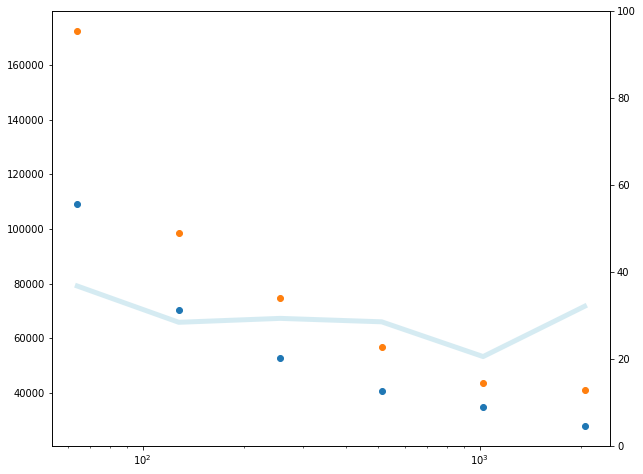

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

In [ ]:
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from matplotlib import cm
# from understandingPINNs.models import PINN
# import torch
# from understandingPINNs import metrics

# for i in range(20):
#   seed = i
#   np.random.seed(seed=seed)
#   for ini in initialcon: 

#     start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

#     delta = (final-start)/0.1
#     delta2 = delta.copy()
#     delta2[0,:] = f1(start)
#     delta2[1,:] = f2(start)
#     dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
#     dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
#     data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

#     """# sumNN"""

    

#     if torch.cuda.is_available():
#       device=torch.device('cuda')
#     else:
#       device=torch.device('cpu')
#     print("device used", device)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

#     import torch.optim as optim
#     import time 


#     sumnet = PINN.SumNet(2,16,2)
#     starttime = time.time() 

#     results = PINN.train(sumnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
#     sumnet, epochs = results[0], results[1]
#     septraintime = time.time()-starttime
#     torch.save(sumnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.pt' %(sys,sys,"sumNN",seed,ini))

#     H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
#     for i in tqdm(range(len(sample_points))):
#       out = get_H_grad(sumnet, sample_points[i], device)
#       H_pred[i] = out[0]
#       dq_pred[i] = out[1]
#       dp_pred[i] = out[2]
#     print(H_pred.shape, dq_pred.shape, dp_pred.shape)
#     file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
#     file_object.write('sumNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
#           %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
#           np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
#           np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
#     file_object.close()
    
#     H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

#     plt.figure(figsize = (10,10))
#     plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
#     plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
#     plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sumNN"))

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from understandingPINNs.models import PINN
import torch
from understandingPINNs import metrics

for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajSympEuler(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/0.1
    delta2 = delta.copy()
    delta2[0,:] = f1(start)
    delta2[1,:] = f2(start)
    dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = PINN.sepNet(1,11,11,1)
    starttime = time.time() 

    results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(sepnet, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a') 
    file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = PINN.Net(2,16,1)
    starttime = time.time() 
    
    results = PINN.train(net,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(net, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a')
    file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    print(septraintime, PINNtraintime)